In [1]:
%load_ext watermark
%watermark -a 'Christian Schuhegger' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,qgrid,rpy2,libpgm,pgmpy,networkx,graphviz,pybnl,pytest

Christian Schuhegger 
last updated: 2018-06-29 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
xarray 0.10.3
scipy 1.0.1
pandas 0.22.0
sklearn 0.19.1
matplotlib 2.2.2
seaborn 0.8.1
qgrid 1.0.2
rpy2 2.9.1
libpgm n
pgmpy n
networkx 2.1
graphviz 0.8.3
pybnl n
pytest 3.5.0


In [2]:
%matplotlib inline
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt, seaborn as sns
import sklearn, sklearn.pipeline, sklearn.model_selection, sklearn.naive_bayes
import networkx as nx, graphviz, networkx.algorithms.dag
import random
import itertools

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext rpy2.ipython

/media/disk2/home/cs/local/install/Anaconda3-5.1.0-Linux-x86_64/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/media/disk2/home/cs/local/install/Anaconda3-5.1.0-Linux-x86_64/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/media/disk2/home/cs/local/install/Anaconda3-5.1.0-Linux-x86_64/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/media/disk2/home/cs/local/install/Anaconda3-5.1.0-Linux-x86_64/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/media/disk2/home/cs/local/install/Anaconda3-5.1.0-Linux-x86_64/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarn

In [5]:
%load_ext autoreload
%autoreload 1
%aimport pybnl.bn

In [6]:
%aimport dsbasics.bin

In [7]:
import locale
locale.setlocale(locale.LC_ALL, 'C')

import rpy2, rpy2.rinterface, rpy2.robjects, rpy2.robjects.packages, rpy2.robjects.lib, rpy2.robjects.lib.grid, \
    rpy2.robjects.lib.ggplot2, rpy2.robjects.pandas2ri, rpy2.interactive.process_revents, \
    rpy2.interactive, rpy2.robjects.lib.grdevices
# rpy2.interactive.process_revents.start()
rpy2.robjects.pandas2ri.activate()

In [8]:
rpackageversionfn = rpy2.robjects.r('packageVersion')
print(rpackageversionfn("bnlearn")[0])
print(rpackageversionfn("gRain")[0])

[1]        4        4 20180620

[1] 1 3 0



# House Prices in Ames, Iowa

* [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf)
  * [AmesResidential.pdf](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesResidential.pdf)
  * [DataDocumentation.txt](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)
  * [AmesHousing.txt](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt)
  * [AmesHousing.xls](http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls)
  * Also on [kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

The below example reproduces the example from chapter 5 (page 79) in [Bayesian Networks and BayesiaLab: A Practical Introduction for Researchers](https://www.amazon.com/Bayesian-Networks-BayesiaLab-Introduction-Researchers/dp/0996533303).

In [9]:
df = pd.read_csv('./AmesHousing.txt.gz', sep='\t', index_col=0)
df['MS SubClass'] = df['MS SubClass'].apply(lambda x: '{0:0>3}'.format(x))
df.iloc[:5,:15]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2
Order,,,,,,,,,,,,,,,
1,526301100,020,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
2,526350040,020,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm
3,526351010,020,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
4,526353030,020,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
5,527105010,060,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm


In [10]:
df.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood D

In [11]:
discrete_non_null, discrete_with_null, continuous_non_null, continuous_with_null, levels_map = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(df, cutoff=30)
# discrete_non_null, discrete_with_null, continuous_non_null, continuous_with_null, levels_map

In [12]:
ddf = df.copy()
#cat_columns = ['Alley', 'Bedroom AbvGr', 'Bldg Type', 'Bsmt Cond', ]
cat_columns = [
    'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
    'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition'
] + [
    'Overall Qual', 'Overall Cond'
]
cat_columns_ordinal = [
    ('Lot Shape',      ['Reg','IR1','IR2','IR3']),
    ('Utilities',      ['AllPub','NoSewr','NoSeWa','ELO']),
    ('Land Slope',     ['Gtl', 'Mod', 'Sev']),
    ('Exter Qual',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Exter Cond',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Bsmt Qual',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Cond',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Exposure',  ['Gd', 'Av', 'Mn', 'No', 'NA']),
    ('BsmtFin Type 1', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('BsmtFin Type 2', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('Heating QC',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Electrical',     ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']),
    ('Kitchen Qual',   ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Functional',     ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']),
    ('Fireplace Qu',   ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Finish',  ['Fin', 'RFn', 'Unf', 'NA']),
    ('Garage Qual',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Cond',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Paved Drive',    ['Y', 'P', 'N']),
    ('Pool QC',        ['Ex', 'Gd', 'TA', 'Fa', 'NA']),
    ('Fence',          ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']),
]

continuous_columns = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
    'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice'
]
discrete_columns = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Mo Sold', 'Yr Sold', 'Bedroom AbvGr', 'Kitchen AbvGr']# do not exist: 'Bedroom',  'Kitchen'

for col in cat_columns:
    levels = levels_map[col]
    # print('col: {}'.format(col))
    # if all([isinstance(level, (int, float)) for level in levels]):
    if all([np.issubdtype(type(level), np.number) for level in levels]):
        # print('int, float column: {}'.format(col))
        levels = sorted(levels)
        ddf[col] = df[col].astype(pd.api.types.CategoricalDtype(levels, ordered=True))
    else:
        ddf[col] = df[col].astype(pd.api.types.CategoricalDtype(levels, ordered=False))

for col, levels in cat_columns_ordinal:
    ddf[col] = df[col].astype(pd.api.types.CategoricalDtype(levels[::-1], ordered=True))

for col in continuous_columns:
    ddf[col] = df[col].astype(float)

for col in discrete_columns:
    if pd.isnull(df[col]).any():
        ddf[col] = df[col].astype(float)
    else:
        ddf[col] = df[col].astype(int)
    
# col   = 'Alley'
# ddf[col]
# ddf[~pd.isnull(ddf[col])][col]
# value = np.nan
# ddf.loc[df[col]==value,col]

[Working with Pandas: Fixing messy column names](https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd)

In [13]:
ddf.columns = ddf.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [14]:
type(ddf.columns)

pandas.core.indexes.base.Index

In [15]:
ddf.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,020,RL,141.0,31770.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5,2010,WD,Normal,215000.0
2,526350040,020,RH,80.0,11622.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NaN,MnPrv,NaN,0.0,6,2010,WD,Normal,105000.0
3,526351010,020,RL,81.0,14267.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NaN,NaN,Gar2,12500.0,6,2010,WD,Normal,172000.0
4,526353030,020,RL,93.0,11160.0,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,4,2010,WD,Normal,244000.0
5,527105010,060,RL,74.0,13830.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NaN,MnPrv,NaN,0.0,3,2010,WD,Normal,189900.0


In [16]:
# ddf.to_hdf('AmesHousing.h5', 'AmesHousing',format='table', append=False)

In [17]:
# pd.read_hdf('AmesHousing.h5', 'AmesHousing').head()

## Treating Filtered Values ('FV')

See page 84 in "Bayesian Networks and BayesiaLab"

### Bsmt fields

In [18]:
bsmt_fields_ = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Full Bath', 'Bsmt Half Bath', 
               'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
bsmt_fields = pd.Index(bsmt_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[bsmt_fields].query('Bsmt_Qual == "NA"')
# ddf[ddf['Bsmt_Qual'] == 'NA'][bsmt_fields]
# df[bsmt_fields_][df['Bsmt Qual'] == 'NA']

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,


It seems that there are no filtered values for 'Bsmt' fields, e.g. each home contains a basement.

[Querying for NaN and other names in Pandas](https://stackoverflow.com/questions/26535563/querying-for-nan-and-other-names-in-pandas)

In [19]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Qual)].head()

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
84,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
155,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
207,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
244,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
274,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df[bsmt_fields_][pd.isnull(df['Bsmt Qual'])].head()

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Bsmt Full Bath,Bsmt Half Bath,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
Order,,,,,,,,,,,
84,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
155,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
207,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
244,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
274,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


But there are quite a lot of 'NaN' entries. Not sure why the data description contains an "NA" value as "No Basement", but no actual data-set uses it. Most likely these values are supposed to be "NA"

In [21]:
bsmt_na_fields = ['Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2']
ddf.loc[pd.isnull(ddf.Bsmt_Qual), bsmt_na_fields] = "NA"
ddf[bsmt_fields].query('Bsmt_Qual == "NA"').head()

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
84,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
155,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
207,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
244,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
274,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0


### Electrical field

In [22]:
ddf.Electrical.value_counts(dropna=False)

SBrkr    2682
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [23]:
ddf[pd.isnull(ddf.Electrical)]

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1578,916386080,080,RL,73.0,9735.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754.0,640.0,0.0,1394.0,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5,2008,WD,Normal,167500.0


The one NaN value seems to be a missing value

### Fireplaces

In [24]:
fireplaces_fields_ = ['Fireplaces', 'Fireplace Qu']
fireplaces_fields = pd.Index(fireplaces_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[fireplaces_fields].query('Fireplaces == 0').head()

,Fireplaces,Fireplace_Qu
Order,,
2,0,NaN
3,0,NaN
7,0,NaN
8,0,NaN
12,0,NaN


In [25]:
ddf.loc[ddf.Fireplaces == 0,['Fireplace_Qu']] = 'NA'
ddf[fireplaces_fields].query('Fireplaces == 0').head()

,Fireplaces,Fireplace_Qu
Order,,
2,0,NA
3,0,NA
7,0,NA
8,0,NA
12,0,NA


### Garage fields

In [26]:
garage_fields_ = ['Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Qual', 'Garage Cond', 'Garage Yr Blt', 'Garage Area']
garage_fields = pd.Index(garage_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[garage_fields][pd.isnull(ddf.Garage_Type)].head()

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
28,NaN,NaN,0.0,NaN,NaN,NaN,0.0
120,NaN,NaN,0.0,NaN,NaN,NaN,0.0
126,NaN,NaN,0.0,NaN,NaN,NaN,0.0
130,NaN,NaN,0.0,NaN,NaN,NaN,0.0
131,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [27]:
ddf['Garage_Type'] = ddf['Garage_Type'].astype(str)\
    .astype(pd.api.types.CategoricalDtype(set(list(ddf.Garage_Type.dtype.categories) + ['NA'])))
ddf.Garage_Type.dtype.categories

Index(['Attchd', 'CarPort', 'Detchd', '2Types', 'NA', 'BuiltIn', 'Basment'], dtype='object')

In [28]:
ddf.loc[pd.isnull(ddf.Garage_Type),['Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond']] = 'NA'
ddf.loc[ddf.Garage_Type == 'NA',['Garage_Yr_Blt']] = -1.0
#ddf[garage_fields][pd.isnull(ddf.Garage_Yr_Blt)]
#ddf['Garage_Yr_Blt'] = ddf['Garage_Yr_Blt'].astype(int)
ddf[garage_fields][ddf.Garage_Type == 'NA'].head()

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
28,NA,NA,0.0,NA,NA,-1.0,0.0
120,NA,NA,0.0,NA,NA,-1.0,0.0
126,NA,NA,0.0,NA,NA,-1.0,0.0
130,NA,NA,0.0,NA,NA,-1.0,0.0
131,NA,NA,0.0,NA,NA,-1.0,0.0


### Mas Vnr fields

In [29]:
mas_vnr_fields_ = ['Mas Vnr Type', 'Mas Vnr Area']
mas_vnr_fields = pd.Index(mas_vnr_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[mas_vnr_fields][pd.isnull(ddf.Mas_Vnr_Type)].head()

,Mas_Vnr_Type,Mas_Vnr_Area
Order,,
56,NaN,NaN
485,NaN,NaN
518,NaN,NaN
539,NaN,NaN
868,NaN,NaN


In [30]:
ddf.Mas_Vnr_Type.dtype

CategoricalDtype(categories=['Stone', 'None', 'BrkFace', 'BrkCmn', 'CBlock'], ordered=False)

In [31]:
ddf.loc[pd.isnull(ddf.Mas_Vnr_Type), ['Mas_Vnr_Type']] = 'None'
ddf.loc[ddf.Mas_Vnr_Type == 'None', ['Mas_Vnr_Area']] = 0.0

In [32]:
ddf[mas_vnr_fields][ddf.Mas_Vnr_Type == 'None'].head()

,Mas_Vnr_Type,Mas_Vnr_Area
Order,,
2,None,0.0
4,None,0.0
5,None,0.0
7,None,0.0
8,None,0.0


### Pool fields

In [33]:
pool_fields_ = ['Pool QC', 'Pool Area']
pool_fields = pd.Index(pool_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[pool_fields][pd.isnull(ddf.Pool_QC)].head()

,Pool_QC,Pool_Area
Order,,
1,NaN,0.0
2,NaN,0.0
3,NaN,0.0
4,NaN,0.0
5,NaN,0.0


In [34]:
ddf.loc[pd.isnull(ddf.Pool_QC), ['Pool_QC']] = 'NA'
ddf[pool_fields][ddf.Pool_QC == 'NA'].head()

,Pool_QC,Pool_Area
Order,,
1,NA,0.0
2,NA,0.0
3,NA,0.0
4,NA,0.0
5,NA,0.0


### Fence field

In [35]:
fence_fields_ = ['Fence']
fence_fields = pd.Index(fence_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf.loc[pd.isnull(ddf.Fence), ['Fence']] = 'NA'
ddf[fence_fields][ddf.Fence == 'NA'].head()

,Fence
Order,
1,NA
3,NA
4,NA
6,NA
7,NA


### Misc Feature field

In [36]:
misc_feature_fields_ = ['Misc Feature']
misc_feature_fields = pd.Index(misc_feature_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf['Misc_Feature'] = ddf['Misc_Feature'].astype(str)\
    .astype(pd.api.types.CategoricalDtype(set(list(ddf.Misc_Feature.dtype.categories) + ['NA'])))
ddf.loc[pd.isnull(ddf.Misc_Feature), ['Misc_Feature']] = 'NA'
ddf[misc_feature_fields][ddf.Misc_Feature == 'NA'].head()

,Misc_Feature
Order,
1,NA
2,NA
4,NA
5,NA
6,NA


### Check remaining nan fields

In [37]:
_, discrete_with_null_, _, continuous_with_null_, _ = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(ddf, cutoff=30)
discrete_with_null_, continuous_with_null_

(['Alley',
  'Bsmt_Exposure',
  'BsmtFin_Type_2',
  'Electrical',
  'Bsmt_Full_Bath',
  'Bsmt_Half_Bath',
  'Garage_Finish',
  'Garage_Cars',
  'Garage_Qual',
  'Garage_Cond'],
 ['Lot_Frontage',
  'BsmtFin_SF_1',
  'BsmtFin_SF_2',
  'Bsmt_Unf_SF',
  'Total_Bsmt_SF',
  'Garage_Yr_Blt',
  'Garage_Area'])

In [38]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Exposure)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
67,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,1595.0,1595.0
1797,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,725.0,725.0
2780,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,936.0,936.0


Just set the few NaN values to 'No'

In [39]:
ddf.loc[pd.isnull(ddf.Bsmt_Exposure),['Bsmt_Exposure']] = 'No'

In [40]:
ddf[bsmt_fields][pd.isnull(ddf.BsmtFin_Type_2)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
445,Gd,TA,No,GLQ,NaN,1.0,0.0,1124.0,479.0,1603.0,3206.0


Just set the few NaN values to 'Unf'

In [41]:
ddf.loc[pd.isnull(ddf.BsmtFin_Type_2),['BsmtFin_Type_2']] = 'Unf'

In [42]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Full_Bath)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
1342,NA,NA,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN
1498,NA,NA,NA,NA,NA,NaN,NaN,0.0,0.0,0.0,0.0


In [43]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Half_Bath)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
1342,NA,NA,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN
1498,NA,NA,NA,NA,NA,NaN,NaN,0.0,0.0,0.0,0.0


Just set all the NaN values to 0.0

In [44]:
ddf.loc[pd.isnull(ddf.Bsmt_Full_Bath),['Bsmt_Full_Bath','Bsmt_Half_Bath','BsmtFin_SF_1','BsmtFin_SF_2','Bsmt_Unf_SF','Total_Bsmt_SF']] = [0.0,0.0,0.0,0.0,0.0,0.0]

In [45]:
ddf[['Electrical']][pd.isnull(ddf.Electrical)]

,Electrical
Order,
1578,NaN


Just set this single NaN value to 'Mix'

In [46]:
ddf.loc[pd.isnull(ddf.Electrical),['Electrical']] = 'Mix'

The remaining NaN garage fields seem to be really missing values so don't touch them.

In [47]:
ddf[garage_fields][pd.isnull(ddf.Garage_Finish)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
1357,Detchd,NaN,1.0,NaN,NaN,NaN,360.0
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
ddf[garage_fields][pd.isnull(ddf.Garage_Cars)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
ddf[garage_fields][pd.isnull(ddf.Garage_Qual)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
1357,Detchd,NaN,1.0,NaN,NaN,NaN,360.0
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
ddf[garage_fields][pd.isnull(ddf.Garage_Cond)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
1357,Detchd,NaN,1.0,NaN,NaN,NaN,360.0
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


The Lot_Frontage NaN fields seem to be really missing values so don't touch them.

In [51]:
ddf[pd.isnull(ddf.Lot_Frontage)].head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,527165230,020,RL,NaN,7980.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187.0,0.0,0.0,1187.0,1.0,0.0,2,0,3,1,TA,6,Typ,0,NA,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483.0,21.0,0.0,0.0,0.0,0.0,NA,GdPrv,Shed,500.0,3,2010,WD,Normal,185000.0
15,527182190,120,RL,NaN,6820.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1985,1985,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,368.0,BLQ,1120.0,0.0,1488.0,GasA,TA,Y,SBrkr,1502.0,0.0,0.0,1502.0,1.0,0.0,1,1,1,1,Gd,4,Typ,0,NA,Attchd,1985.0,RFn,2.0,528.0,TA,TA,Y,0.0,54.0,0.0,0.0,140.0,0.0,NA,NA,NA,0.0,6,2010,WD,Normal,212000.0
23,527368020,060,FV,NaN,7500.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,533.0,Unf,0.0,281.0,814.0,GasA,Ex,Y,SBrkr,814.0,860.0,0.0,1674.0,1.0,0.0,2,1,3,1,Gd,7,Typ,0,NA,Attchd,2000.0,RFn,2.0,663.0,TA,TA,Y,0.0,96.0,0.0,0.0,0.0,0.0,NA,NA,NA,0.0,1,2010,WD,Normal,216000.0
24,527402200,020,RL,NaN,11241.0,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004.0,0.0,0.0,1004.0,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NA,NA,Shed,700.0,3,2010,WD,Normal,149000.0
25,527402250,020,RL,NaN,12537.0,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1971,2008,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,734.0,Unf,0.0,344.0,1078.0,GasA,Ex,Y,SBrkr,1078.0,0.0,0.0,1078.0,1.0,0.0,1,1,3,1,TA,6,Typ,1,Fa,Attchd,1971.0,Fin,2.0,500.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NA,NA,NA,0.0,4,2010,WD,Normal,149900.0


In [52]:
_, discrete_with_null_, _, continuous_with_null_, _ = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(ddf, cutoff=30)
discrete_with_null_, continuous_with_null_

(['Alley', 'Garage_Finish', 'Garage_Cars', 'Garage_Qual', 'Garage_Cond'],
 ['Lot_Frontage', 'Garage_Yr_Blt', 'Garage_Area'])

## Binning / Discretization

In [53]:
ddf1 = ddf.copy()

### The target variable is SalePrice

In [54]:
ddf.SalePrice.describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [55]:
ddf1.SalePrice = pd.cut(ddf.SalePrice, [0.0,75000.0, 150000.0, 225000.0, 300000.0,np.PINF], right=False)
ddf1['SalePrice'].value_counts()

[75000.0, 150000.0)     1195
[150000.0, 225000.0)    1043
[225000.0, 300000.0)     396
[300000.0, inf)          238
[0.0, 75000.0)            58
Name: SalePrice, dtype: int64

### Continuous, discrete and ordinal variables

In [56]:
continuous_columns_without_sale_price = list(set(continuous_columns) - set(['SalePrice']))

In [57]:
target_variable_decision_tree_binning_variables_ = [c for c,r in cat_columns_ordinal] + continuous_columns_without_sale_price + discrete_columns + ['Overall Qual', 'Overall Cond']
target_variable_decision_tree_binning_variables = pd.Index(target_variable_decision_tree_binning_variables_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
target_variable_decision_tree_binning_variables

Index(['Lot_Shape', 'Utilities', 'Land_Slope', 'Exter_Qual', 'Exter_Cond', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating_QC', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence', 'Lot_Area', 'Low_Qual_Fin_SF', 'Garage_Area', 'Mas_Vnr_Area', 'Total_Bsmt_SF', 'Enclosed_Porch', 'BsmtFin_SF_1', 'Bsmt_Unf_SF', 'Lot_Frontage', 'BsmtFin_SF_2', 'Pool_Area', 'Gr_Liv_Area', '2nd_Flr_SF', 'Screen_Porch', 'Misc_Val', '3Ssn_Porch', 'Wood_Deck_SF', 'Open_Porch_SF', '1st_Flr_SF', 'Year_Built', 'Year_Remod/Add', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Yr_Blt', 'Garage_Cars', 'Mo_Sold', 'Yr_Sold', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'Overall_Qual', 'Overall_Cond'], dtype='object')

In [58]:
tvbt = dsbasics.bin.TargetVariableDecisionTreeBinTransformer(max_leaf_nodes=3)
ddf1.loc[:,target_variable_decision_tree_binning_variables] = \
    tvbt.fit_transform(ddf[target_variable_decision_tree_binning_variables], ddf1.SalePrice)
ddf1.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,020,RL,"[81.5, 314.0)","[10532.5, 215246.0)",Pave,NaN,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]",[5],"[1872.0, 1984.5)","[1950.0, 1985.5)",Hip,CompShg,BrkFace,Plywood,Stone,"[1.5, 183.5)","[Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]","[Gd,Ex]",[Gd],"[Unf,LwQ,Rec,BLQ,ALQ]","[0.0, 982.5)",[Unf],"[0.0, 3.0)","[28.5, 1042.5)","[0.0, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1389.5, 5096.0)","[0.0, 813.5)","[0.0, 66.5)","[1488.5, 1969.5)","[0.5, 1.5)","[0.0, 0.5)","[0.0, 1.5)","[0.0, 0.5)","[2.5, 3.5)","[0.5, 1.5)","[Po,Fa,TA]","[6.5, 8.5)",[Typ],"[1.5, 5.0)","[TA,Gd]",Attchd,"[-1.0, 1987.5)",[Fin],"[1.5, 2.5)","[387.0, 627.5)",[TA],"[TA,Gd]",[P],"[155.5, 1425.0)","[30.5, 743.0)","[0.0, 17.0)","[0.0, 151.5)","[0.0, 136.5)","[0.0, 72.0)",[NA],[NA],NA,"[0.0, 27.0)","[1.5, 5.5)","[2009.5, 2011.0)",WD,Normal,"[150000.0, 225000.0)"
2,526350040,020,RH,"[71.5, 81.5)","[10532.5, 215246.0)",Pave,NaN,[Reg],Lvl,[AllPub],Inside,[Gtl],NAmes,Feedr,Norm,1Fam,1Story,"[1,2,3,4,5,6]","[6,7,8,9]","[1872.0, 1984.5)","[1950.0, 1985.5)",Gable,CompShg,VinylSd,VinylSd,None,"[0.0, 1.5)","[Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[0.0, 982.5)","[LwQ,Rec,BLQ,ALQ,GLQ]","[3.0, 964.0)","[28.5, 1042.5)","[0.0, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[334.0, 1078.5)","[0.0, 813.5)","[0.0, 66.5)","[334.0, 1488.5)","[0.0, 0.5)","[0.0, 0.5)","[0.0, 1.5)","[0.0, 0.5)","[0.0, 2.5)","[0.5, 1.5)","[Po,Fa,TA]","[2.0, 6.5)",[Typ],"[0.0, 0.5)","[NA,Po,Fa]",Attchd,"[-1.0, 1987.5)","[NA,Unf]","[0.0, 1.5)","[627.5, 1489.0)",[TA],"[TA,Gd]",[Y],"[96.5, 155.5)","[0.0, 11.5)","[0.0, 17.0)","[0.0, 151.5)","[0.0, 136.5)","[0.0, 72.0)",[NA],"[MnWw,GdWo,MnPrv]",NA,"[0.0, 27.0)","[5.5, 13.0)","[2009.5, 2011.0)",WD,Normal,"[75000.0, 150000.0)"
3,526351010,020,RL,"[71.5, 81.5)","[10532.5, 215246.0)",Pave,NaN,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]","[6,7,8,9]","[1872.0, 1984.5)","[1950.0, 1985.5)",Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,"[1.5, 183.5)","[Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[0.0, 982.5)",[Unf],"[0.0, 3.0)","[28.5, 1042.5)","[1217.5, 1681.0)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1078.5, 1389.5)","[0.0, 813.5)","[0.0, 66.5)","[334.0, 1488.5)","[0.0, 0.5)","[0.0, 0.5)","[0.0, 1.5)","[0.5, 1.5)","[2.5, 3.5)","[0.5, 1.5)",[Gd],"[2.0, 6.5)",[Typ],"[0.0, 0.5)","[NA,Po,Fa]",Attchd,"[-1.0, 1987.5)","[NA,Unf]","[0.0, 1.5)","[0.0, 387.0)",[TA],"[TA,Gd]",[Y],"[155.5, 1425.0)","[30.5, 743.0)","[0.0, 17.0)","[0.0, 151.5)","[0.0, 136.5)","[0.0, 72.0)",[NA],[NA],Gar2,"[1250.0, 17001.0)","[5.5, 13.0)","[2009.5, 2011.0)",WD,Normal,"[150000.0, 225000.0)"
4,526353030,020,RL,"[81.5, 314.0)","[10532.5, 215246.0)",Pave,NaN,[Reg],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,[7],[5],"[1872.0, 1984.5)","[1950.0, 1985.5)",Hip,CompShg,BrkFace,BrkFace,None,"[0.0, 1.5)",[Gd],[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[

In [59]:
len(df.columns),len(ddf1.columns)

(81, 81)

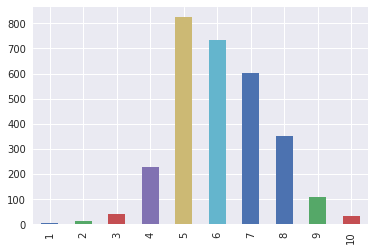

In [60]:
ddf['Overall_Qual'].value_counts().sort_index().plot(kind='bar');

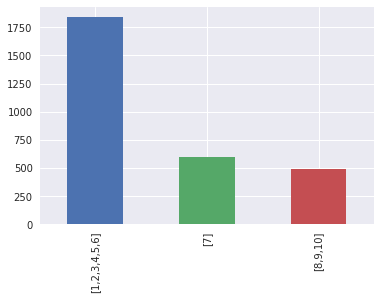

In [61]:
ddf1['Overall_Qual'].value_counts().sort_index().plot(kind='bar');

### Convert interval indices to strings

In [62]:
ddf1 = pybnl.bn.convert_interval_index_categories_to_string_categories(ddf1,inplace=False)

In [63]:
ddf1.Bsmt_Full_Bath.dtype

CategoricalDtype(categories=['[0.0, 0.5)', '[0.5, 1.5)', '[1.5, 4.0)'], ordered=True)

### Rename columns to fit with R conventions

In [64]:
ddf1 = ddf1.rename(columns={
    "1st_Flr_SF":"X1st_Flr_SF",
    "2nd_Flr_SF":"X2nd_Flr_SF",
    "3Ssn_Porch":"X3Ssn_Porch",
    "Year_Remod/Add":"Year_Remod_Add"
})

### Drop unused columns

In [65]:
if any(ddf1.columns.isin(['PID'])):
    ddf1.drop('PID', axis=1, inplace=True)
# ddf1.columns

#### Drop the 'Alley' column, which contains most null values and will not contribute to the quality of the fit

In [66]:
if any(ddf1.columns.isin(['Alley'])):
    ddf1.drop('Alley', axis=1, inplace=True)
# ddf1.columns

The remaining columns with null values are:

In [67]:
_, discrete_with_null_, _, continuous_with_null_, _ = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(ddf1, cutoff=30)
discrete_with_null_, continuous_with_null_

(['Lot_Frontage',
  'Garage_Yr_Blt',
  'Garage_Finish',
  'Garage_Cars',
  'Garage_Area',
  'Garage_Qual',
  'Garage_Cond'],
 [])

The statistics of the NaN values are as follows. Only the column `Lot_Frontage` still has relevant null values, e.g. we could simply filter out the 2 `Garage` rows that contain null values:

In [68]:
display_side_by_side(
    pd.DataFrame(ddf1.Lot_Frontage.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Yr_Blt.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Finish.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Cars.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Area.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Qual.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Cond.value_counts(dropna=False))
)

,Lot_Frontage
"[21.0, 71.5)",1411
"[81.5, 314.0)",544
NaN,490
"[71.5, 81.5)",485
,Garage_Yr_Blt
"[-1.0, 1987.5)",1690
"[1987.5, 2005.5)",912
"[2005.5, 2208.0)",326
NaN,2
,Garage_Finish


In [69]:
null_value_idx = pd.isnull(ddf1.Lot_Frontage) | pd.isnull(ddf1.Garage_Yr_Blt) | pd.isnull(ddf1.Garage_Finish) | \
    pd.isnull(ddf1.Garage_Cars) | pd.isnull(ddf1.Garage_Area) | pd.isnull(ddf1.Garage_Qual) | pd.isnull(ddf1.Garage_Cond)
null_value_idx.value_counts()

False    2438
True      492
dtype: int64

In [70]:
ddf_without_null_values = ddf1[~null_value_idx]

In [71]:
ddf_with_null_values = ddf1

## Naive Bayes Classifier

### bnlearn by hand

#### Define net

In [72]:
dg = nx.DiGraph()

dg.add_nodes_from(ddf1.columns.values)

in_vars = ddf1.columns.values[:-1]
out_var = ddf1.columns.values[-1:]
dg.add_edges_from(list(itertools.product(out_var, in_vars)))

In [73]:
ns = pybnl.bn.digraph2netstruct(dg)
# ns.dot()
display(HTML(ns.dot()._repr_svg_()))

In [74]:
nbn1 = pybnl.bn.NetAndDataDiscreteBayesNetwork(ldf=ddf_without_null_values, dg=dg, predict_var='SalePrice')
nbn1.fit();

In [75]:
N=20 # restricted to speed up runtime of notebook
y_pred = nbn1.predict(ddf_without_null_values.iloc[:N,:-1])

100%|██████████| 20/20 [00:00<00:00, 26.66it/s]


In [76]:
y_true = ddf_without_null_values.iloc[:N,-1:]

In [77]:
sklearn.metrics.accuracy_score(y_true, y_pred)

0.95

In [78]:
tmp_cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
tmp_cm

array([[13,  0,  0,  1],
       [ 0,  2,  0,  0],
       [ 0,  0,  2,  0],
       [ 0,  0,  0,  2]])

In [79]:
np.diag(tmp_cm).sum()/tmp_cm.sum()

0.95

In [80]:
nbn1.arc_strength_info().head()

,from,to,strength,rs,rmif,rmit
0,SalePrice,Neighborhood,-1086.172919,1.000000,0.344832,0.153247
1,SalePrice,Overall_Qual,-963.928136,0.887454,0.306023,0.429010
2,SalePrice,Garage_Cars,-814.157718,0.749565,0.258474,0.339345
3,SalePrice,Bsmt_Qual,-780.101563,0.718211,0.247662,0.341725
4,SalePrice,Exter_Qual,-759.623713,0.699358,0.241161,0.392364


In [81]:
nbn1.arc_strength_info().tail()

,from,to,strength,rs,rmif,rmit
73,SalePrice,Land_Slope,-8.583311,0.007902,0.002725,0.018697
74,SalePrice,Bsmt_Half_Bath,-7.907456,0.007280,0.002510,0.014344
75,SalePrice,X3Ssn_Porch,-5.215486,0.004802,0.001656,0.040316
76,SalePrice,Utilities,-3.819061,0.003516,0.001212,0.434047
77,SalePrice,Yr_Sold,-3.369036,0.003102,0.001070,0.001417


In [82]:
display(HTML(nbn1.dot()._repr_svg_()))

### bnlearn via naive.bayes

In [83]:
mbn = pybnl.bn.MultinomialNB()
mbn.fit(ddf_without_null_values[in_vars], ddf_without_null_values[out_var[0]])

MultinomialNB()

In [84]:
nbn1.arc_strength_info().head()

,from,to,strength,rs,rmif,rmit
0,SalePrice,Neighborhood,-1086.172919,1.000000,0.344832,0.153247
1,SalePrice,Overall_Qual,-963.928136,0.887454,0.306023,0.429010
2,SalePrice,Garage_Cars,-814.157718,0.749565,0.258474,0.339345
3,SalePrice,Bsmt_Qual,-780.101563,0.718211,0.247662,0.341725
4,SalePrice,Exter_Qual,-759.623713,0.699358,0.241161,0.392364


In [85]:
tmp_df = pd.DataFrame([
    mbn.predict(ddf_without_null_values[in_vars]),
    ddf_without_null_values[out_var[0]].reset_index(drop=True),    
])
tmp_df.head()

,0,1
0,"[150000.0, 225000.0)","[150000.0, 225000.0)"
1,"[75000.0, 150000.0)","[75000.0, 150000.0)"
2,"[75000.0, 150000.0)","[150000.0, 225000.0)"
3,"[225000.0, 300000.0)","[225000.0, 300000.0)"
4,"[150000.0, 225000.0)","[150000.0, 225000.0)"


In [86]:
sklearn.metrics.accuracy_score(tmp_df.iloc[:,1], tmp_df.iloc[:,0])

0.7612797374897456

In [87]:
tmp_cm = sklearn.metrics.confusion_matrix(tmp_df.iloc[:,1], tmp_df.iloc[:,0])
tmp_cm

array([[ 48,   0,   0,   0,   6],
       [  0, 490, 153,   1, 172],
       [  0,  47, 215,  47,   3],
       [  0,   4,  23, 189,   0],
       [ 56,  68,   2,   0, 914]])

In [88]:
# display(HTML(mbn.dot()._repr_svg_()))

In [89]:
mbn.predict_proba(ddf_without_null_values[in_vars]).head()

,"[0.0, 75000.0)","[75000.0, 150000.0)","[150000.0, 225000.0)","[225000.0, 300000.0)","[300000.0, inf)"
Order,,,,,
1,0.000000e+00,1.454981e-04,0.999819,0.000035,0.000000e+00
2,1.371047e-07,9.999978e-01,0.000002,0.000000,0.000000e+00
3,0.000000e+00,9.181823e-01,0.081818,0.000000,0.000000e+00
4,0.000000e+00,5.443282e-09,0.031744,0.968247,9.125987e-06
5,0.000000e+00,7.612794e-13,0.999256,0.000744,3.806638e-13


In [90]:
tmp_df = pd.DataFrame([
    mbn.predict(ddf_without_null_values[in_vars]),
    mbn.predict_proba(ddf_without_null_values[in_vars]).max(axis=1).reset_index(drop=True),
    ddf_without_null_values[out_var[0]].reset_index(drop=True),
    mbn.predict_proba(
        ddf_without_null_values[in_vars]
    ).values[
        np.array(range(len(ddf_without_null_values))).reshape(-1,1),
        ddf_without_null_values[out_var[0]].values.codes.reshape(-1,1)
    ].reshape(-1)
])
tmp_df.head()

,0,1,2,3
0,"[150000.0, 225000.0)",0.999819,"[150000.0, 225000.0)",0.999819
1,"[75000.0, 150000.0)",0.999998,"[75000.0, 150000.0)",0.999998
2,"[75000.0, 150000.0)",0.918182,"[150000.0, 225000.0)",0.081818
3,"[225000.0, 300000.0)",0.968247,"[225000.0, 300000.0)",0.968247
4,"[150000.0, 225000.0)",0.999256,"[150000.0, 225000.0)",0.999256


### sklearn MultinomialNB

In [91]:
clf = sklearn.naive_bayes.MultinomialNB()
X_ = ddf_without_null_values[in_vars]
X  = X_.apply(lambda x: x.cat.codes, axis=0)
y_ = ddf_without_null_values[out_var[0]]
y  = y_.cat.codes
clf.fit(X, y)
# 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [92]:
tmp_df = pd.DataFrame([
    pybnl.bn.from_codes_to_category(
        clf.predict(X),y_.dtype),
    clf.predict_proba(X).max(axis=1),
    y_.reset_index(drop=True),    
    clf.predict_proba(X)[np.array(range(len(y))).reshape(-1,1),y.values.reshape(-1,1)].reshape(-1)
])
tmp_df.head()

,0,1,2,3
0,"[300000.0, inf)",0.772444,"[150000.0, 225000.0)",0.013989
1,"[75000.0, 150000.0)",0.660452,"[75000.0, 150000.0)",0.660452
2,"[150000.0, 225000.0)",0.965183,"[150000.0, 225000.0)",0.965183
3,"[300000.0, inf)",0.916943,"[225000.0, 300000.0)",0.082732
4,"[150000.0, 225000.0)",0.841099,"[150000.0, 225000.0)",0.841099


In [93]:
y_.dtype.categories

Index(['[0.0, 75000.0)', '[75000.0, 150000.0)', '[150000.0, 225000.0)', '[225000.0, 300000.0)', '[300000.0, inf)'], dtype='object')

In [94]:
sklearn.metrics.accuracy_score(y, clf.predict(X))

0.6739130434782609

In [95]:
sklearn.metrics.precision_score(y, clf.predict(X), average='micro')

0.6739130434782609

In [96]:
sklearn.metrics.recall_score(y, clf.predict(X), average='micro')

0.6739130434782609

In [97]:
sklearn.metrics.f1_score(y, clf.predict(X), average='micro')

0.6739130434782609

In [98]:
# sklearn.metrics.roc_auc_score(y, tmp_df.iloc[:,3], average='micro')

In [99]:
# vertically: true label
# horizontally: predicted label
tmp_cm = sklearn.metrics.confusion_matrix(y, clf.predict(X))
tmp_cm

array([[ 43,  11,   0,   0,   0],
       [ 79, 793, 165,   1,   2],
       [  0, 153, 459, 180,  24],
       [  0,  12,  52, 184,  64],
       [  0,   0,   8,  44, 164]])

In [100]:
np.diag(tmp_cm).sum()/tmp_cm.sum()

0.6739130434782609

* [Tutorial on MultinomialNB](http://universityofbigdata.net/competition/tutorial/5681717746597888?lang=en)
* [Vectorization, Multinomial Naive Bayes Classifier and Evaluation](https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/)
* [Computing cross-validated metrics](http://scikit-learn.org/stable/modules/cross_validation.html)

In [101]:
clf_cv = sklearn.naive_bayes.MultinomialNB(alpha=1.0)
# scores = sklearn.model_selection.cross_val_score(clf_cv, X, y, cv=10, scoring='accuracy')
# cv = sklearn.model_selection.KFold(n_splits=10, shuffle=False, random_state=0)
cv = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=False, random_state=0)
# cv = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
scores = sklearn.model_selection.cross_val_score(clf_cv, X, y, cv=cv, scoring='accuracy')
np.mean(scores), np.std(scores)

(0.6586532536027023, 0.04509103471552344)

In [102]:
y_.dtype.categories

Index(['[0.0, 75000.0)', '[75000.0, 150000.0)', '[150000.0, 225000.0)', '[225000.0, 300000.0)', '[300000.0, inf)'], dtype='object')

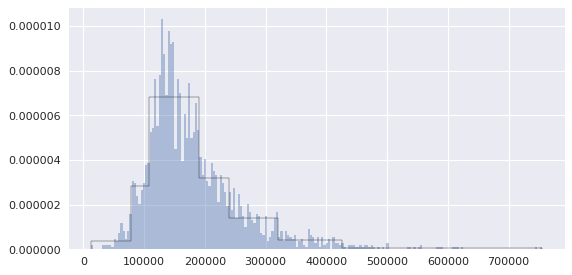

In [103]:
bbt1 = dsbasics.bin.BayesianBlocksBinTransformer(p0=0.01)
bbt1.fit(ddf['SalePrice'].values.reshape(-1,1))
bbt2 = dsbasics.bin.BayesianBlocksBinTransformer(neg_ln_gamma=30)
bbt2.fit(ddf['SalePrice'].values.reshape(-1,1))
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot()
ax.hist(ddf['SalePrice'], bins=200, histtype='stepfilled', alpha=0.4, density=True);
ax.hist(ddf['SalePrice'], bins=bbt2.bins_[0], histtype='step', color='black', density=True);

In [104]:
ddf_without_null_values_saleprice = ddf.loc[ddf_without_null_values.index]['SalePrice']

tmp_saleprice_category_to_mean_mapping = \
    ddf_without_null_values_saleprice.groupby(ddf_without_null_values['SalePrice']).mean()
tmp_saleprice_category_to_mean_mapping_dict = \
    dict(zip(tmp_saleprice_category_to_mean_mapping.index, tmp_saleprice_category_to_mean_mapping.values))
tmp_saleprice_category_to_mean_mapping

SalePrice
[0.0, 75000.0)           57011.703704
[75000.0, 150000.0)     121711.443269
[150000.0, 225000.0)    181043.667892
[225000.0, 300000.0)    254889.615385
[300000.0, inf)         380633.032407
Name: SalePrice, dtype: float64

In [105]:
tmp_y_pred = ddf_without_null_values['SalePrice'].map(tmp_saleprice_category_to_mean_mapping)
tmp_y_real = ddf_without_null_values_saleprice
tmp_pred_vs_real_df = pd.concat([tmp_y_pred, tmp_y_real], axis=1)
tmp_pred_vs_real_df.columns = ['pred', 'real']
tmp_pred_vs_real_df.head()

,pred,real
Order,,
1,181043.667892,215000.0
2,121711.443269,105000.0
3,181043.667892,172000.0
4,254889.615385,244000.0
5,181043.667892,189900.0


In [106]:
np.sqrt(sklearn.metrics.mean_squared_error(tmp_pred_vs_real_df.real, tmp_pred_vs_real_df.pred))

30055.88674085552

In [107]:
sklearn.metrics.median_absolute_error(tmp_pred_vs_real_df.real, tmp_pred_vs_real_df.pred)

16082.026253770746

In [108]:
sklearn.metrics.mean_absolute_error(tmp_pred_vs_real_df.real, tmp_pred_vs_real_df.pred)

20025.400797108665

In [109]:
sklearn.metrics.explained_variance_score(tmp_pred_vs_real_df.real, tmp_pred_vs_real_df.pred)

0.8704337725927475

## End to end sklearn pipeline

In [110]:
df.iloc[:5,:15]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2
Order,,,,,,,,,,,,,,,
1,526301100,020,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
2,526350040,020,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm
3,526351010,020,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
4,526353030,020,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
5,527105010,060,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm


In [111]:
cat_columns = [
    'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
    'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition'
] + [
    'Overall Qual', 'Overall Cond'
]
cat_columns_ordinal = [
    ('Lot Shape',      ['Reg','IR1','IR2','IR3']),
    ('Utilities',      ['AllPub','NoSewr','NoSeWa','ELO']),
    ('Land Slope',     ['Gtl', 'Mod', 'Sev']),
    ('Exter Qual',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Exter Cond',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Bsmt Qual',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Cond',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Exposure',  ['Gd', 'Av', 'Mn', 'No', 'NA']),
    ('BsmtFin Type 1', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('BsmtFin Type 2', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('Heating QC',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Electrical',     ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']),
    ('Kitchen Qual',   ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Functional',     ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']),
    ('Fireplace Qu',   ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Finish',  ['Fin', 'RFn', 'Unf', 'NA']),
    ('Garage Qual',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Cond',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Paved Drive',    ['Y', 'P', 'N']),
    ('Pool QC',        ['Ex', 'Gd', 'TA', 'Fa', 'NA']),
    ('Fence',          ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']),
]

continuous_columns = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
    'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice'
]
discrete_columns = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Mo Sold', 'Yr Sold', 'Bedroom AbvGr', 'Kitchen AbvGr']# do not exist: 'Bedroom',  'Kitchen'


In [112]:
cat_columns_NA = [
    ('Misc Feature', ['Shed', 'Gar2', 'Othr', 'TenC', 'Elev', 'NA']),
    ('Garage Type', ['Attchd', 'Detchd', 'BuiltIn', 'Basment', '2Types', 'CarPort', 'NA']),
]

In [113]:
df['Garage Type'].value_counts(dropna=False)

Attchd     1731
Detchd      782
BuiltIn     186
NaN         157
Basment      36
2Types       23
CarPort      15
Name: Garage Type, dtype: int64

In [114]:
tmp_cat_columns_ordinal = [e for e,_ in cat_columns_ordinal]
# tmp_cat_columns_ordinal

In [115]:
tmp_cat_columns_NA = [(e, 'NA') for e,_ in cat_columns_NA]
tmp_cat_columns_NA

[('Misc Feature', 'NA'), ('Garage Type', 'NA')]

In [116]:
tmp_cat_columns_ordinal_1 = [(e, l[::-1]) for e,l in cat_columns_ordinal + cat_columns_NA]
tmp_levels_map = dict(tmp_cat_columns_ordinal_1)
# tmp_levels_map

In [148]:
metadata = {}
it = dsbasics.bin.MetaDataInitTransformer(metadata)
st = dsbasics.bin.ColumnNameSanitzerTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = tmp_cat_columns_ordinal, 
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    metadata=metadata
)

ct = dsbasics.bin.CategoricalTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = tmp_cat_columns_ordinal, 
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    levels_map = tmp_levels_map,
    metadata=metadata
)

nt = dsbasics.bin.NullToNATransformer(null_to_NA_columns = tmp_cat_columns_NA, metadata=metadata)

lt = dsbasics.bin.CategoryLevelsAsStringsTransformer()

pl = sklearn.pipeline.Pipeline(
    memory=None,
    steps=[
        ('init', it),
        ('cn_sanitizer', st),
        ('ct', ct),
        ('null_to_NA', nt),
        ('levels_as_strings', lt)
          ])

tmp = pl.fit_transform(df.iloc[:,:-1], df.SalePrice)
tmp.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,X1st_Flr_SF,X2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,X3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,020,RL,141.0,31770.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NaN,NaN,NA,0.0,5,2010,WD,Normal
2,526350040,020,RH,80.0,11622.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NaN,MnPrv,NA,0.0,6,2010,WD,Normal
3,526351010,020,RL,81.0,14267.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NaN,NaN,Gar2,12500.0,6,2010,WD,Normal
4,526353030,020,RL,93.0,11160.0,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NA,0.0,4,2010,WD,Normal
5,527105010,060,RL,74.0,13830.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NaN,MnPrv,NA,0.0,3,2010,WD,Normal


In [144]:
tmp.Garage_Type.value_counts(dropna=False)

Attchd     1731
Detchd      782
BuiltIn     186
NA          157
Basment      36
2Types       23
CarPort      15
Name: Garage_Type, dtype: int64

In [ ]:
'Overall Qual'

In [119]:
dsbasics.bin.sanitize_column_names(pd.Series(['1A', '(A)', '(A/B)']))

['X1A', 'A', 'A_B']